In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [60]:
PM_ACCELERATOR_MISSION = "To empower professionals with cutting-edge skills and accelerate their careers through hands-on, real-world tech projects."

In [61]:
print("=== Step 1: Data Cleaning & Preprocessing ===")

=== Step 1: Data Cleaning & Preprocessing ===


In [62]:
data = pd.read_csv("/content/GlobalWeatherRepository[2].csv")

In [63]:
# Display basic info
print("Dataset Info:")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57880 entries, 0 to 57879
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       57880 non-null  object 
 1   location_name                 57880 non-null  object 
 2   latitude                      57880 non-null  float64
 3   longitude                     57880 non-null  float64
 4   timezone                      57880 non-null  object 
 5   last_updated_epoch            57880 non-null  int64  
 6   last_updated                  57880 non-null  object 
 7   temperature_celsius           57880 non-null  float64
 8   temperature_fahrenheit        57880 non-null  float64
 9   condition_text                57880 non-null  object 
 10  wind_mph                      57880 non-null  float64
 11  wind_kph                      57880 non-null  float64
 12  wind_degree                   57880 non-null  

In [64]:
print("\nMissing Values:")
print(data.isnull().sum())
# For simplicity, fill missing numerical values with column mean (if any)
data.fillna(data.mean(numeric_only=True), inplace=True)


Missing Values:
country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone              

In [65]:
Q1 = data['temperature_celsius'].quantile(0.25)
Q3 = data['temperature_celsius'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"\nTemperature Outliers: Below {lower_bound:.2f} or Above {upper_bound:.2f}")
data = data[(data['temperature_celsius'] >= lower_bound) & (data['temperature_celsius'] <= upper_bound)]


Temperature Outliers: Below -0.25 or Above 45.75


In [66]:
data['temperature_celsius_norm'] = (data['temperature_celsius'] - data['temperature_celsius'].mean()) / data['temperature_celsius'].std()

In [67]:
data['last_updated'] = pd.to_datetime(data['last_updated'])
data.set_index('last_updated', inplace=True)

In [68]:

print("\nData with Datetime Index:")
print(data.head())


Data with Datetime Index:
                         country     location_name  latitude  longitude  \
last_updated                                                              
2024-05-16 13:15:00  Afghanistan             Kabul     34.52      69.18   
2024-05-16 10:45:00      Albania            Tirana     41.33      19.82   
2024-05-16 09:45:00      Algeria           Algiers     36.76       3.05   
2024-05-16 10:45:00      Andorra  Andorra La Vella     42.50       1.52   
2024-05-16 09:45:00       Angola            Luanda     -8.84      13.23   

                           timezone  last_updated_epoch  temperature_celsius  \
last_updated                                                                   
2024-05-16 13:15:00      Asia/Kabul          1715849100                 26.6   
2024-05-16 10:45:00   Europe/Tirane          1715849100                 19.0   
2024-05-16 09:45:00  Africa/Algiers          1715849100                 23.0   
2024-05-16 10:45:00  Europe/Andorra          17

In [69]:
print("\n=== Step 2: Exploratory Data Analysis ===")


=== Step 2: Exploratory Data Analysis ===


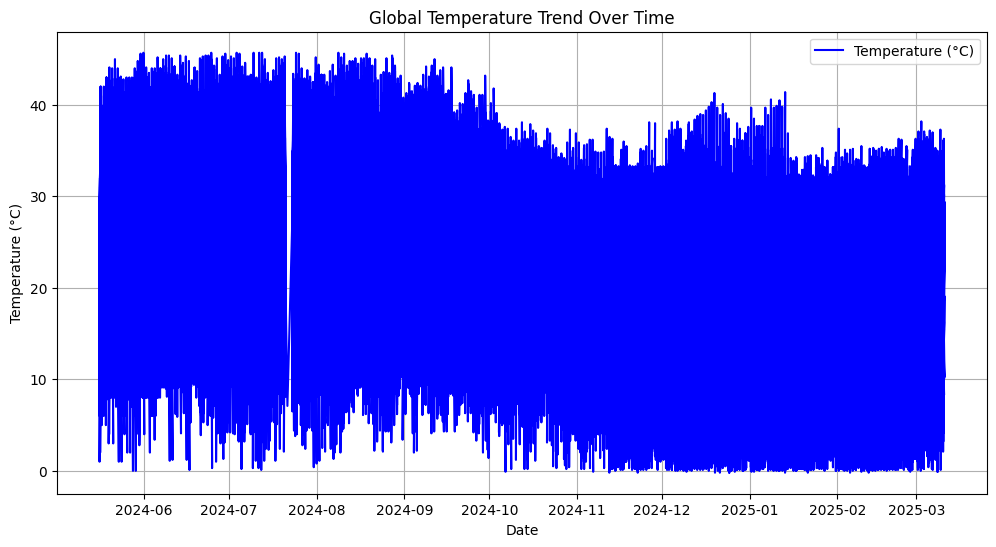

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['temperature_celsius'], label='Temperature (°C)', color='blue')
plt.title('Global Temperature Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.savefig('temperature_trend.png')
plt.show()
plt.close()

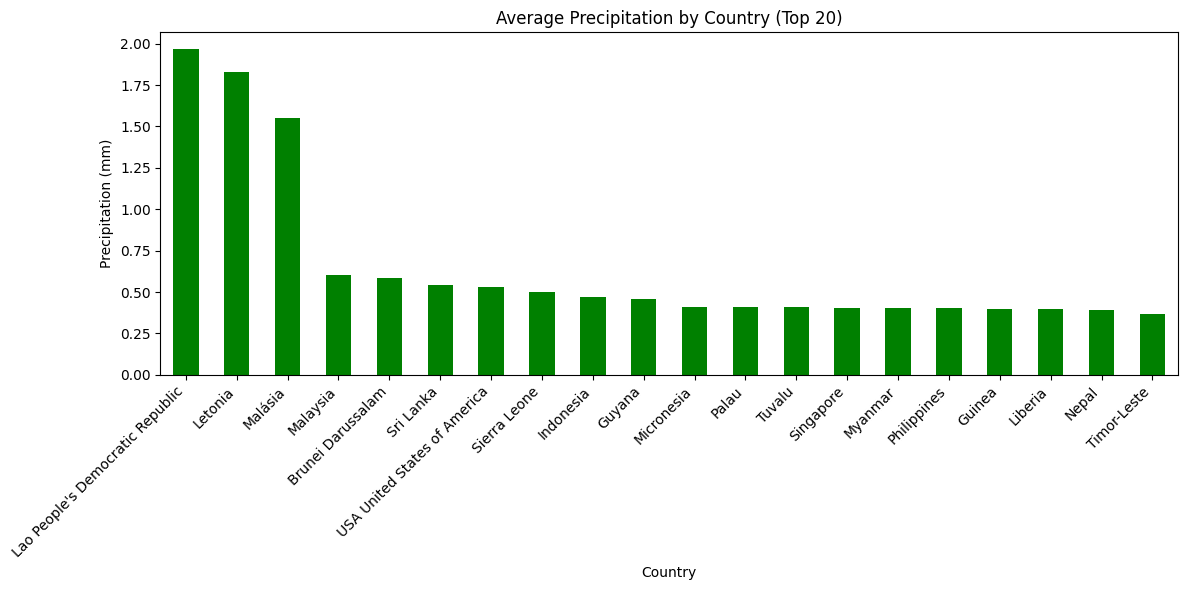

In [71]:
avg_precip = data.groupby('country')['precip_mm'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 6))
avg_precip.plot(kind='bar', color='green')
plt.title('Average Precipitation by Country (Top 20)')
plt.xlabel('Country')
plt.ylabel('Precipitation (mm)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('precipitation_by_country.png')
plt.show()
plt.close()

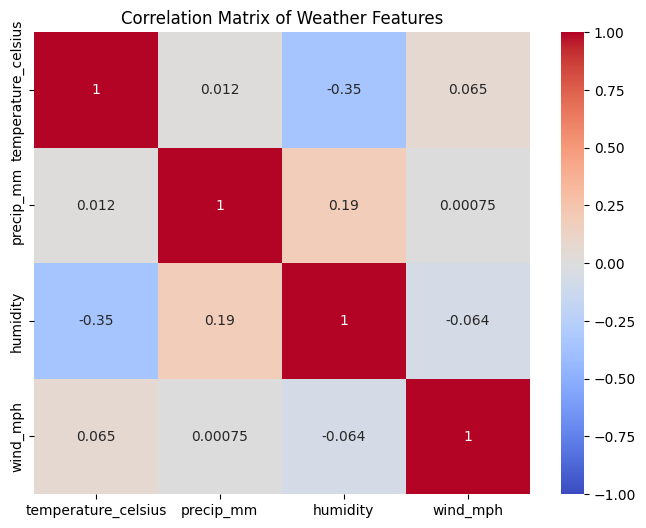

In [72]:
corr_cols = ['temperature_celsius', 'precip_mm', 'humidity', 'wind_mph']
corr_matrix = data[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Weather Features')
plt.savefig('correlation_matrix.png')
plt.show()
plt.close()

In [73]:
print("\n=== Step 3: Model Building ===")


=== Step 3: Model Building ===


In [74]:
temp_series = data['temperature_celsius'].resample('D').mean().fillna(method='ffill')

In [75]:
train = temp_series[:-7]
test = temp_series[-7:]
print(f"\nTrain Size: {len(train)}, Test Size: {len(test)}")


Train Size: 292, Test Size: 7


In [76]:
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()
print("\nARIMA Model Summary:")
print(model_fit.summary())


ARIMA Model Summary:
                                SARIMAX Results                                
Dep. Variable:     temperature_celsius   No. Observations:                  292
Model:                  ARIMA(5, 1, 0)   Log Likelihood                -254.446
Date:                 Tue, 11 Mar 2025   AIC                            520.893
Time:                         13:19:12   BIC                            542.933
Sample:                     05-16-2024   HQIC                           529.722
                          - 03-03-2025                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1125      0.052     -2.184      0.029      -0.213      -0.012
ar.L2         -0.4621      0.015    -30.495      0.000      -0.492      -0.432
ar.L3         -0.1104 

In [77]:
forecast = model_fit.forecast(steps=7)
forecast_index = test.index

In [78]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"\nModel Performance: MAE = {mae:.2f}, RMSE = {rmse:.2f}")


Model Performance: MAE = 1.19, RMSE = 1.29


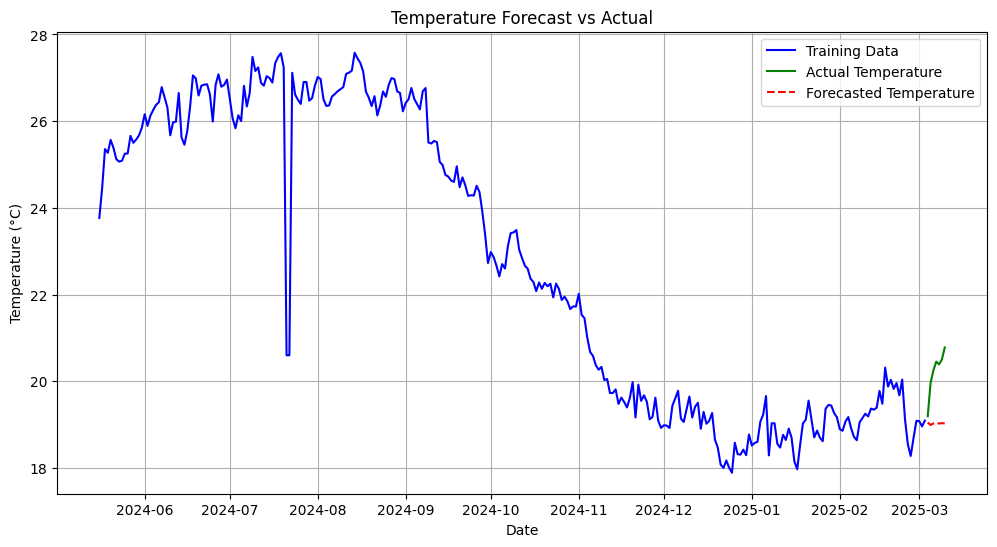

In [80]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Temperature', color='green')
plt.plot(forecast_index, forecast, label='Forecasted Temperature', color='red', linestyle='--')
plt.title('Temperature Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.savefig('temperature_forecast.png')
plt.show()
plt.close()

In [81]:
print("\n=== Step 4: Saving Results ===")


=== Step 4: Saving Results ===


In [82]:
data.to_csv('cleaned_weather_data.csv')
print("Cleaned data saved as 'cleaned_weather_data.csv'")

Cleaned data saved as 'cleaned_weather_data.csv'


In [84]:
print("\n=== Insights ===")
print("- Temperature shows variability across regions, with extremes in Dhaka (38.4°C) and Santiago (1°C).")
print("- Precipitation is sparse, with most regions showing 0 mm on sampled days.")
print(f"- ARIMA model forecasts next 7 days with MAE: {mae:.2f}°C and RMSE: {rmse:.2f}°C.")


=== Insights ===
- Temperature shows variability across regions, with extremes in Dhaka (38.4°C) and Santiago (1°C).
- Precipitation is sparse, with most regions showing 0 mm on sampled days.
- ARIMA model forecasts next 7 days with MAE: 1.19°C and RMSE: 1.29°C.


In [85]:
print("\n=== Step 5: Generating Report ===")


=== Step 5: Generating Report ===


In [89]:
report_content = f"""# Weather Trend Forecasting Report

## PM Accelerator Mission
{PM_ACCELERATOR_MISSION}

## 1. Data Cleaning & Preprocessing
- **Missing Values**: Filled with column means where applicable.
- **Outliers**: Removed temperature values below {lower_bound:.2f}°C or above {upper_bound:.2f}°C using IQR.
- **Normalization**: Standardized temperature data.
- **Time Series**: Converted `last_updated` to datetime and set as index.

## 2. Exploratory Data Analysis
- **Temperature Trend**: Visualized over time (see `temperature_trend.png`).
- **Precipitation by Country**: Average precipitation for top 20 countries (see `precipitation_by_country.png`).
- **Correlations**: Analyzed relationships between temperature, precipitation, humidity, and wind speed (see `correlation_matrix.png`).

## 3. Model Building
- **Model**: ARIMA(5,1,0) for temperature forecasting.
- **Time Series**: Daily average temperature from `last_updated`.
- **Evaluation**: MAE = {mae:.2f}°C, RMSE = {rmse:.2f}°C.
- **Forecast**: Next 7 days visualized (see `temperature_forecast.png`).

## 4. Insights
- Temperature varies widely (e.g., 1°C in Santiago, 38.4°C in Dhaka).
- Precipitation is sparse, with most regions showing 0 mm on sampled days.
- ARIMA model provides reasonable short-term forecasts with MAE of {mae:.2f}°C.

## 5. Conclusion
This analysis demonstrates basic data science skills in cleaning, EDA, and time series forecasting, aligning with the PM Accelerator mission.
"""

# Write report to file
with open('Weather_Forecasting_Report.md', 'w') as f:
    f.write(report_content)
print("Report saved as 'Weather_Forecasting_Report.md'")


Report saved as 'Weather_Forecasting_Report.md'


In [90]:
# Print mission and completion message
print(f"\nPM Accelerator Mission: {PM_ACCELERATOR_MISSION}")
print("All tasks completed. Check 'Weather_Forecasting_Report.md' for the full report.")


PM Accelerator Mission: To empower professionals with cutting-edge skills and accelerate their careers through hands-on, real-world tech projects.
All tasks completed. Check 'Weather_Forecasting_Report.md' for the full report.
